###NOTE:

To run this notebook, the files 'training_history.zip' and 'final_dataset.csv' are needed.

In [ ]:
!pip install transformers

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from pylab import rcParams

#### Settings for plotting figures

In [3]:
sns.set(style='whitegrid')
sns.set_palette(sns.color_palette("bright"))
rcParams['figure.figsize'] = 10, 6

In [4]:
def pretty_print_cm(cm):
    labels_sorted = sorted(labels)
    hmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(labels_sorted, rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(labels_sorted, rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label');

#### Read in data

In [ ]:
!unzip '/content/training_history.zip' -d '/content/'

In [6]:
df = pd.read_csv('final_dataset.csv')
df.columns = ['sentence', 'original_label', 'thread_id', 'comment_id', 'label']
df = df.drop_duplicates(subset=['thread_id', 'sentence'])

# Select test thread ids
test_ids = ['t3_6rwcio', 't3_5jfqhp', 't3_71l9yj', 't3_4mj8v7', 't3_58t7i3',
            't3_64kkxe', 't3_6ihcuk', 't3_5o7nm3', 't3_4tf91m', 't3_4q9qng']
val_ids = ['t3_5ep0mh', 't3_4pbwvb', 't3_4g3nbn', 't3_6tsx1p', 't3_62igvv',
           't3_6694ui', 't3_6h7a4i', 't3_4plwqq', 't3_4otmqi', 't3_57tl4k']

df_train = df[~(df['thread_id'].isin((test_ids + val_ids)))][['sentence', 'label']]
df_val = df[df['thread_id'].isin(val_ids)][['sentence', 'label']]
df_test = df[df['thread_id'].isin(test_ids)][['sentence', 'label']]

## Data inspection

### Distribution of topics

In [52]:
topics_df = pd.read_csv('topics.csv')
topic_dist = pd.concat([topics_df.topic.value_counts(),
             topics_df.topic.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'], axis=1)
topic_dist.columns = ['Count', 'Percentage']
topic_dist

,Count,Percentage
Social Justice,12,24.0%
Politics,11,22.0%
Human Life,8,16.0%
Philosophy,6,12.0%
Religion,3,6.0%
Technology,3,6.0%
Economics,2,4.0%
Energy,1,2.0%
Entertainment,1,2.0%
Health,1,2.0%


In [16]:
runs = ['bs16_lr2e-5', 'bs16_lr3e-5', 'bs16_lr5e-5', 'bs32_lr2e-5', 'bs32_lr3e-5', 'bs32_lr5e-5']
labels = ['Anecdote', 'Assumption', 'Definition', 'Testimony', 'Statistics/Study', 'Other', 'None']

In [66]:
train_dist = df_train['label'].value_counts().sort_index(ascending=True)
val_dist = df_val['label'].value_counts().sort_index(ascending=True)
test_dist = df_test['label'].value_counts().sort_index(ascending=True)
split_dist = pd.concat([train_dist, val_dist, test_dist], axis=1)
split_dist.columns = ['Train', 'Validation', 'Test']
split_dist

,Train,Validation,Test
Anecdote,402,168,157
Assumption,2356,827,795
Definition,92,32,19
None,1042,252,252
Other,27,12,23
Statistics/Study,41,17,42
Testimony,32,6,21


#**BERT**

---

### Create dataframes with validation loss, train loss, f1 scores and balanced accuracy per run during training

In [63]:
l = ['Anecdote             0.525',
'Common ground        0.103',
'Assumption           0.339',
'Continue             0.400',
'Other                0.240',
'Statistics/Study     0.708',
'Testimony            0.236',
'Definition           0.361',
'None                 0.346']
l1 = [a.split()[0] for a in l]
l2 = [a.split()[1] for a in l]
dfiaa = pd.DataFrame(columns=['Label', 'Fleiss K'])
dfiaa['Label']=l1
dfiaa['Fleiss K']=l2
dfiaa

,Label,Fleiss K
0,Anecdote,0.525
1,Common,ground
2,Assumption,0.339
3,Continue,0.400
4,Other,0.240
5,Statistics/Study,0.708
6,Testimony,0.236
7,Definition,0.361
8,None,0.346


In [11]:
df_val_loss_bert = pd.DataFrame()
df_train_loss_bert = pd.DataFrame()
df_f1_bert = pd.DataFrame()
df_balanced_acc_bert = pd.DataFrame()

for run in runs:
    run_file = pd.read_csv('/content/training_history/BERT_training_history/'+run+'.csv')
    df_val_loss_bert[run] = run_file['Validation Loss']
    df_train_loss_bert[run] = run_file['Training Loss']
    df_f1_bert[run] = run_file['Macro f1']
    df_balanced_acc_bert[run] = run_file['Balanced accuracy']

df_val_loss_bert.index += 1
df_val_loss_bert.index.name = 'epoch'
df_train_loss_bert.index += 1
df_train_loss_bert.index.name = 'epoch'
df_f1_bert.index += 1
df_f1_bert.index.name = 'epoch'
df_balanced_acc_bert.index += 1
df_balanced_acc_bert.index.name = 'epoch'

### Plot training metrics

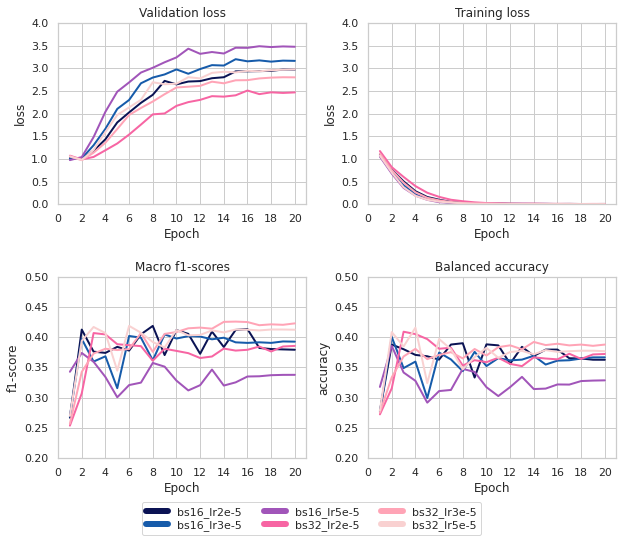

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
colors = ['#0B1354', '#165BAA', '#A155B9', '#F765A3', '#FFA4B6', '#F9D1D1']
lines = []

# Validation loss 
for i, run in enumerate(runs):
    line, = ax1.plot(df_val_loss_bert[run], label=run, color=colors[i], linewidth=2)
    lines.append(line)
ax1.set_title('Validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 4])
ax1.set_xticks([i for i in range(0, 21, 2)])

# Train loss
for i, run in enumerate(runs):
    ax2.plot(df_train_loss_bert[run], label=run, color=colors[i], linewidth=2)
ax2.set_title('Training loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 4])
ax2.set_xticks([i for i in range(0, 21, 2)])

# Macro f1-scores
for i, run in enumerate(runs):
    ax3.plot(df_f1_bert[run], label=run, color=colors[i], linewidth=2)
ax3.set_title('Macro f1-scores')
ax3.set_ylabel('f1-score')
ax3.set_xlabel('Epoch')
ax3.set_ylim([0.2, 0.5])
ax3.set_xticks([i for i in range(0, 21, 2)])

# Balanced accuracy
for i, run in enumerate(runs):
    ax4.plot(df_balanced_acc_bert[run], label=run, color=colors[i], linewidth=2)
ax4.set_title('Balanced accuracy')
ax4.set_ylabel('accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylim([0.2, 0.5])
ax4.set_xticks([i for i in range(0, 21, 2)])

fig.subplots_adjust(wspace=0.25, hspace=0.4)
legend = plt.figlegend(lines, runs, loc='lower center', ncol=3, labelspacing=0.2, borderaxespad=0.1)
for legobj in legend.legendHandles:
    legobj.set_linewidth(6)

plt.show()

### Load fine-tuned BERT model from Hugging Face Hub

In [ ]:
model_finetuned = 'marieke93/BERT-evidence-types'
tokenizer = AutoTokenizer.from_pretrained(model_finetuned)
evidence_classifier = pipeline('text-classification', model=model_finetuned, tokenizer=tokenizer)

results_bert = [evidence_classifier(sentence) for sentence in df_test.sentence]

### Classification report of test predictions BERT

In [17]:
from sklearn.metrics import classification_report
test_preds = [result[0]['label'] for result in results_bert]
print(classification_report(df_test['label'], test_preds, zero_division=0))

                  precision    recall  f1-score   support

        Anecdote       0.78      0.58      0.67       157
      Assumption       0.80      0.87      0.83       795
      Definition       0.20      0.11      0.14        19
            None       0.61      0.73      0.66       252
           Other       1.00      0.04      0.08        23
Statistics/Study       0.73      0.26      0.39        42
       Testimony       0.00      0.00      0.00        21

        accuracy                           0.75      1309
       macro avg       0.59      0.37      0.40      1309
    weighted avg       0.74      0.75      0.73      1309



#### Print confusion matrix

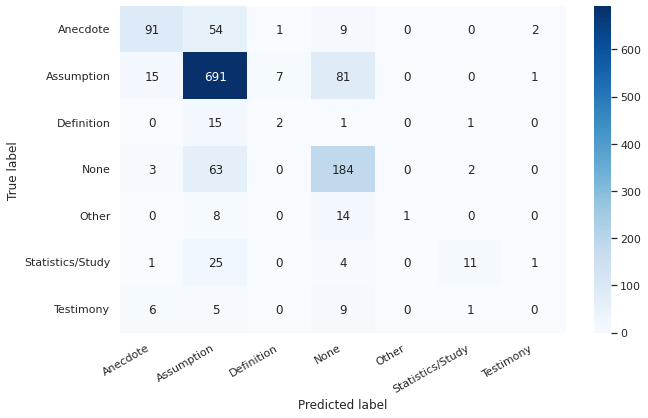

In [18]:
cm = confusion_matrix(df_test['label'], test_preds)
pretty_print_cm(cm)

### Create dataframe with f1-scores per label per epoch of the validation predictions

In [19]:
predictions_per_epoch_df = pd.read_csv('/content/training_history/val_predictions_BERT_bs32_lr3e-5.csv')
labels = ['Anecdote', 'Assumption', 'Definition', 'Testimony', 'Statistics/Study', 'Other', 'None']
f1_scores_df = pd.DataFrame(columns=labels)
for col in predictions_per_epoch_df.columns[1:]:
    f1_scores = f1_score(predictions_per_epoch_df['true'], predictions_per_epoch_df[col], average=None, labels=labels)
    f1_scores_df.loc[len(f1_scores_df)] = f1_scores

f1_scores_df.index += 1
f1_scores_df.index.name = 'epoch'

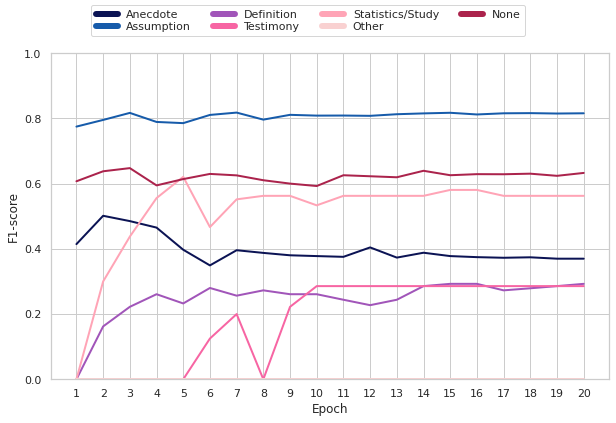

In [20]:
colors = ['#0B1354', '#165BAA', '#A155B9', '#F765A3', '#FFA4B6', '#F9D1D1', '#AB234C']
lines = []
for i, l in enumerate(labels):
    line, = plt.plot(f1_scores_df[l], label=l, color=colors[i], linewidth=2)
    lines.append(line)
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xticks([i+1 for i in range(20)])
legend = plt.figlegend(lines, labels, loc='upper center', ncol=4, labelspacing=0.2)
for legobj in legend.legendHandles:
    legobj.set_linewidth(6)

plt.show()

#**MiniLM**

---

### Create dataframes with validation loss, train loss, f1 scores andn balanced accuracy per run during training

In [21]:
df_val_loss_minilm = pd.DataFrame()
df_train_loss_minilm = pd.DataFrame()
df_f1_minilm = pd.DataFrame()
df_balanced_acc_minilm = pd.DataFrame()

for run in runs:
    run_file = pd.read_csv('/content/training_history/MiniLM_training_history/'+run+'.csv')
    df_val_loss_minilm[run] = run_file['Validation Loss']
    df_train_loss_minilm[run] = run_file['Training Loss']
    df_f1_minilm[run] = run_file['Macro f1']
    df_balanced_acc_minilm[run] = run_file['Balanced accuracy']

df_val_loss_minilm.index += 1
df_val_loss_minilm.index.name = 'epoch'
df_train_loss_minilm.index += 1
df_train_loss_minilm.index.name = 'epoch'
df_f1_minilm.index += 1
df_f1_minilm.index.name = 'epoch'
df_balanced_acc_minilm.index += 1
df_balanced_acc_minilm.index.name = 'epoch'

### Plot training metrics

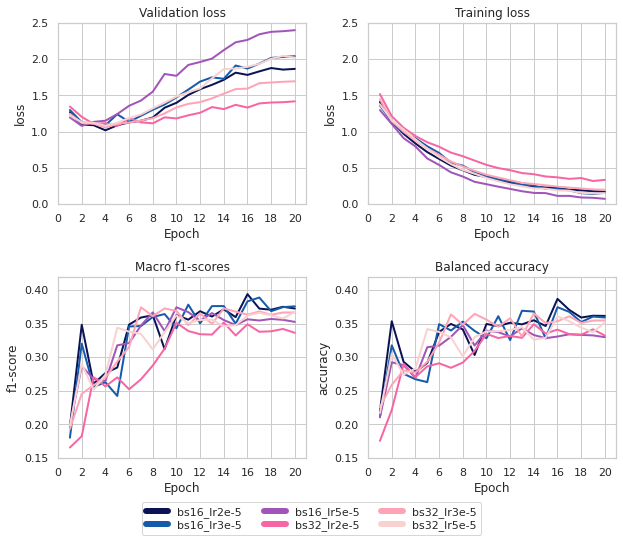

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
colors = ['#0B1354', '#165BAA', '#A155B9', '#F765A3', '#FFA4B6', '#F9D1D1']
lines = []

# Validation loss 
for i, run in enumerate(runs):
    line, = ax1.plot(df_val_loss_minilm[run], label=run, color=colors[i], linewidth=2)
    lines.append(line)
ax1.set_title('Validation loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 2.5])
ax1.set_xticks([i for i in range(0, 21, 2)])

# Train loss
for i, run in enumerate(runs):
    ax2.plot(df_train_loss_minilm[run], label=run, color=colors[i], linewidth=2)
ax2.set_title('Training loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 2.5])
ax2.set_xticks([i for i in range(0, 21, 2)])

# Macro f1-scores
for i, run in enumerate(runs):
    ax3.plot(df_f1_minilm[run], label=run, color=colors[i], linewidth=2)
ax3.set_title('Macro f1-scores')
ax3.set_ylabel('f1-score')
ax3.set_xlabel('Epoch')
ax3.set_ylim([0.15, 0.42])
ax3.set_xticks([i for i in range(0, 21, 2)])

# Balanced accuracy
for i, run in enumerate(runs):
    ax4.plot(df_balanced_acc_minilm[run], label=run, color=colors[i], linewidth=2)
ax4.set_title('Balanced accuracy')
ax4.set_ylabel('accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylim([0.15, 0.42])
ax4.set_xticks([i for i in range(0, 21, 2)])

fig.subplots_adjust(wspace=0.25, hspace=0.4)
legend = plt.figlegend(lines, runs, loc='lower center', ncol=3, labelspacing=0.2, borderaxespad=0.1)
for legobj in legend.legendHandles:
    legobj.set_linewidth(6)

plt.show()

### Load fine-tuned MiniLM model from Hugging Face Hub


In [ ]:
model_finetuned = 'marieke93/MiniLM-evidence-types'
tokenizer = AutoTokenizer.from_pretrained(model_finetuned)
evidence_classifier = pipeline('text-classification', model=model_finetuned, tokenizer=tokenizer)

results_minilm = [evidence_classifier(sentence) for sentence in df_test.sentence]

### Classification report of test predictions MiniLM

In [24]:
from sklearn.metrics import classification_report
test_preds = [result[0]['label'] for result in results_minilm]
print(classification_report(df_test['label'], test_preds, zero_division=0))

                  precision    recall  f1-score   support

        Anecdote       0.66      0.64      0.65       157
      Assumption       0.81      0.82      0.82       795
      Definition       0.36      0.26      0.30        19
            None       0.56      0.71      0.63       252
           Other       0.00      0.00      0.00        23
Statistics/Study       0.64      0.33      0.44        42
       Testimony       0.00      0.00      0.00        21

        accuracy                           0.73      1309
       macro avg       0.43      0.40      0.40      1309
    weighted avg       0.71      0.73      0.71      1309



### Print confusion matrix

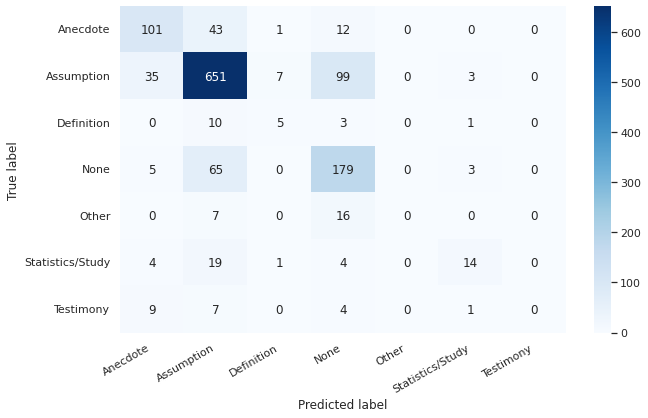

In [25]:
cm = confusion_matrix(df_test['label'], test_preds)
pretty_print_cm(cm)

### Create dataframe with f1-scores per label per epoch of the validation predictions

In [28]:
predictions_per_epoch_df = pd.read_csv('/content/training_history/val_predictions_MiniLM_bs16_lr2e-5.csv')
labels = ['Anecdote', 'Assumption', 'Definition', 'Testimony', 'Statistics/Study', 'Other', 'None']
f1_scores_df = pd.DataFrame(columns=labels)
for col in predictions_per_epoch_df.columns[1:]:
    f1_scores = f1_score(predictions_per_epoch_df['true'], predictions_per_epoch_df[col], average=None, labels=labels)
    f1_scores_df.loc[len(f1_scores_df)] = f1_scores

f1_scores_df.index += 1
f1_scores_df.index.name = 'epoch'        

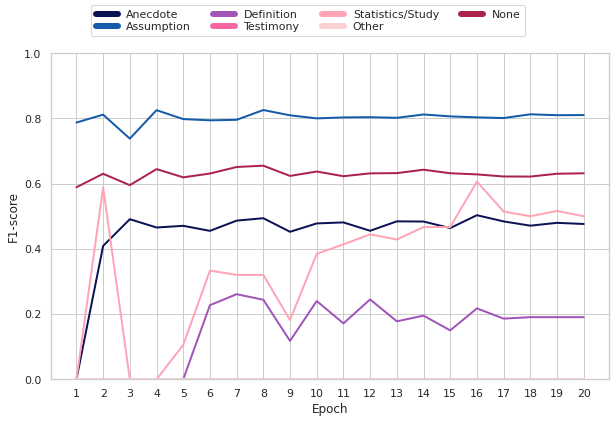

In [29]:
colors = ['#0B1354', '#165BAA', '#A155B9', '#F765A3', '#FFA4B6', '#F9D1D1', '#AB234C']
lines = []
for i, l in enumerate(labels):
    line, = plt.plot(f1_scores_df[l], label=l, color=colors[i], linewidth=2)
    lines.append(line)
plt.ylabel('F1-score')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xticks([i+1 for i in range(20)])
legend = plt.figlegend(lines, labels, loc='upper center', ncol=4, labelspacing=0.2)
for legobj in legend.legendHandles:
    legobj.set_linewidth(6)

plt.show()